In [1]:
from Inverse import *
from q_method import *

In [2]:
N = 64
k = [20]
m = 64
maxq = 0.1
q_method = 'G'
noise_level = 0.0
gtol = 1e-10
maxiter = 20

In [5]:
sys.path.append('/data/liuziyang/Programs/pde_solver')
if isinstance(k,str):
    tmp_k = k.split(',')
    k = [float(eval(item)) for item in tmp_k]
k_len = len(k)
NET = torch.load('/data/liuziyang/Programs/pde_solver/Network/k20_P_4,64,uniform_G_0.1_NST_R200_12,32,4_2.pth')
q = q_gen(N, q_method, maxq)
Q = q.reshape(-1, )
Q0 = Q*0
matrix_A = gen_A(N)
Matrix_analysis(N)
f_data = np.zeros((k_len,m,(N+1)**2),dtype = np.complex128)
partial_data = np.zeros((k_len,m,4*N-4),dtype = np.complex128)
for j in range(k_len):
    f_data[j] = f_gen(N, k[j], m)
    partial_data[j] = pdata_gen(N, Q, k[j], f_data[j], matrix_A,noise_level)

f_data_torch = torch.stack([torch.from_numpy(f_data.reshape(k_len,m,(N+1),(N+1)).real).to(torch.float32).to(device),
                           torch.from_numpy(f_data.reshape(k_len,m,(N+1),(N+1)).imag).to(torch.float32).to(device)],2)
partial_data_torch = torch.stack([torch.from_numpy(partial_data.reshape(k_len,m,4*N-4).real).to(torch.float32).to(device),
                           torch.from_numpy(partial_data.reshape(k_len,m,4*N-4).imag).to(torch.float32).to(device)],2)
matrix_A_torch = torch.from_numpy(matrix_A).to(torch.float32).to(device)
matrix_A_torch = matrix_A_torch.unsqueeze(0).unsqueeze(1).repeat(m,2,1,1)
f_data = (f_data, f_data_torch)
partial_data = (partial_data,partial_data_torch)
matrix_A = (matrix_A,matrix_A_torch)

CPU times: user 1min 43s, sys: 2.97 s, total: 1min 46s
Wall time: 3.31 s
CPU times: user 5.12 s, sys: 166 ms, total: 5.29 s
Wall time: 196 ms
MUMPS: 0.0
NET:   0.00013560998730207137
相对误差为inf%


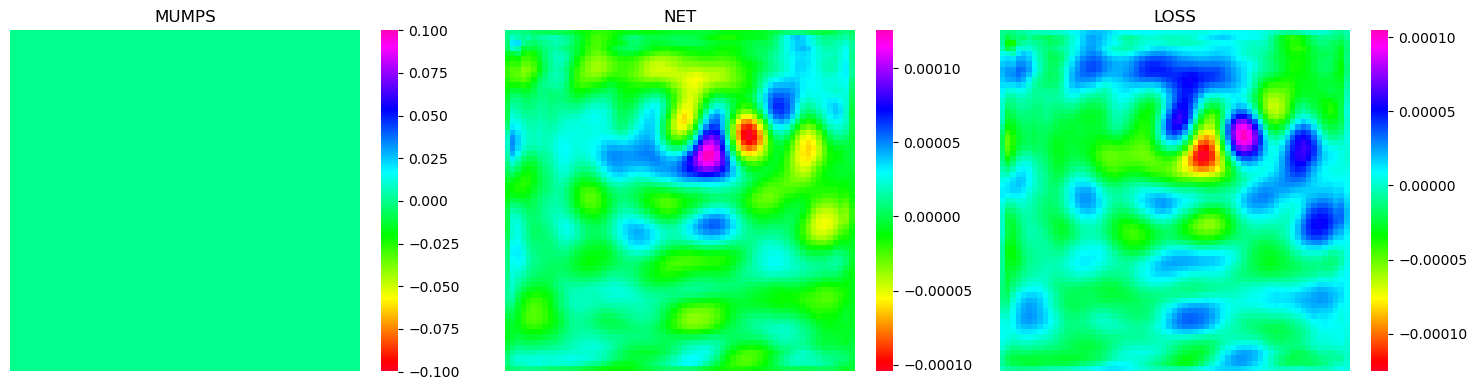

In [6]:
%time data_np = J_MUMPS(Q,N,partial_data[0][0],k[0],f_data[0][0],matrix_A[0])
%time data_torch = J_NET(Q,N,partial_data[1][0],k[0],f_data[1][0],matrix_A[1],NET,device,3)
print('MUMPS: {}'.format(data_np[0]))
print('NET:   {}'.format(data_torch[0]))
heatmap_for_test(data_np[1].reshape(65,65),data_torch[1].reshape(65,65),['MUMPS','NET','LOSS'],loss = True)

In [71]:
def q_T(N, q_value_1 = 1, q_value_2 = -1, x1 = 0.2, x2 = 0.4,
        x3 = 0.7, y1 = 0.2, y2 = 0.3, y3 = 0.6, y4 = 0.7):
    q = np.zeros((N + 1, N + 1))
    q[int(x1 * N):int(x2 * N), int(y1 * N):int(y4 * N)] = q_value_1
    q[int(x2 * N):int(x3 * N), int(y2 * N):int(y3 * N)] = q_value_2
    return q


def q_Gaussian(N, b1 = 0.3, b2 = 0.6, a1 = 150, a2 = 70, gamma = 1):
    """
    q(x,y) = \gamma * \\exp (  -a1(x-b)^2   -a2(y-b2)^2    )
    """
    q = np.zeros((N+1, N+1))
    tmp = np.linspace(1, N-1, N-1)/ N
    Y, X = np.meshgrid(tmp, tmp)
    q[1:-1, 1:-1] = gamma * np.exp(-a1*(X-b1)**2)*np.exp(-a2*(Y-b2)**2)
    return q


def q_Continuous(N):
    q = np.zeros((N+1, N+1))
    tmp = np.linspace(1, N-1, N-1)/ N
    Y, X = np.meshgrid(tmp, tmp)
    X, Y = 6 * X - 3, 6 * Y - 3
    q[1:-1, 1:-1] = 0.3 * (1 - X) ** 2 * np.exp(-X ** 2 - (Y + 1) ** 2) - \
                    (0.2 * X - X ** 3 - Y ** 5) * np.exp(-X ** 2 - Y ** 2) - \
                    0.03 * np.exp(-(X + 1) ** 2 - Y ** 2)
    return q


def q_test(N):
    q1 = np.zeros((N+1, N+1))
    q2 = np.zeros((N+1, N+1))
    random.seed(1234)
    for i in range(5):
        x_axis = random.uniform(0.2,0.8)
        y_axis = random.uniform(0.2,0.8)
        R1 = random.uniform(50,150)
        R2 = random.uniform(50,150)
        gamma = random.uniform(-1,1)
        q1 += q_Gaussian(N, x_axis, y_axis, R1, R2, gamma)
    for i in range(5):
        x_axis = random.uniform(0.2,0.8)
        y_axis = random.uniform(0.2,0.8)
        R1 = random.uniform(50,150)
        R2 = random.uniform(50,150)
        gamma = random.uniform(-1,1)
        q2 += q_Gaussian(N, x_axis, y_axis, R1, R2, gamma)
    return q1+q2
    
    
def q_gen(N, method = 'T', gamma = 1):
    """
    Returns.shape = (N+1,N+1)
    """
    q = np.zeros((N+1,N+1))
    if method == 'T':
        q = q_T(N)
    elif method == 'G':
        q = q_Gaussian(N)
    elif method == 'C':
        q = q_Continuous(N)
    elif method == 'MG':
        q += q_Gaussian(N, 0.3, 0.6, 150, 70, 1)
        q -= q_Gaussian(N, 0.5, 0.3, 120, 80, 0.8)
        q += q_Gaussian(N, 0.8, 0.5, 40, 90, 0.3)
    elif method == 'TEST':
        q = q_test(N)
    Max_Value = np.max(np.abs(q))
    return gamma * q / Max_Value

In [72]:
q = q_gen(128,'TEST')

<AxesSubplot:>

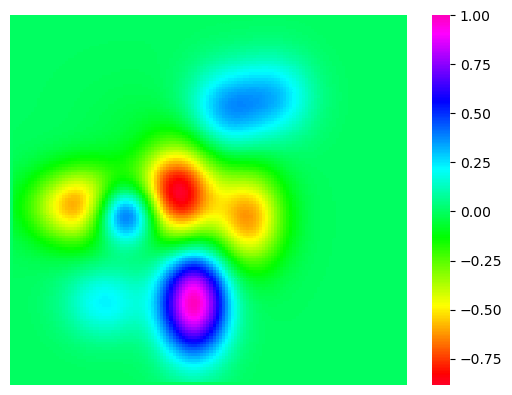

In [73]:
sns.heatmap(q,**heatmap_params)

In [46]:
random.uniform(0.2,0.8)

0.6029380888927911

In [64]:
def q_test(N):
    q1 = np.zeros((N+1, N+1))
    q2 = np.zeros((N+1, N+1))
    random.seed(1234)
    for i in range(5):
        x_axis = random.uniform(0.2,0.8)
        y_axis = random.uniform(0.2,0.8)
        R1 = random.uniform(50,150)
        R2 = random.uniform(50,150)
        gamma = random.uniform(-1,1)
        print(x_axis,y_axis)
        q1 += q_Gaussian(N, x_axis, y_axis, R1, R2, gamma)
    for i in range(5):
        x_axis = random.uniform(0.2,0.8)
        y_axis = random.uniform(0.2,0.8)
        R1 = random.uniform(50,150)
        R2 = random.uniform(50,150)
        gamma = random.uniform(-1,1)
        print(x_axis,y_axis)
        q2 += q_Gaussian(N, x_axis, y_axis, R1, R2, gamma)
    return q1,q2

In [78]:
import numpy as np
from scipy.ndimage import gaussian_filter

# 构造输入的 numpy.array 对象
img = np.array([[1., 2, 3],
                [4, 5, 6],
                [7, 8, 9]])

# 指定高斯核的标准差
sigma = 1

# 进行 Gaussian 模糊处理
blurred = gaussian_filter(img, sigma)

# 输出模糊后的图像
print(blurred)

[[2.68829507 3.2662213  3.84414753]
 [4.42207377 5.         5.57792623]
 [6.15585247 6.7337787  7.31170493]]


<AxesSubplot:>

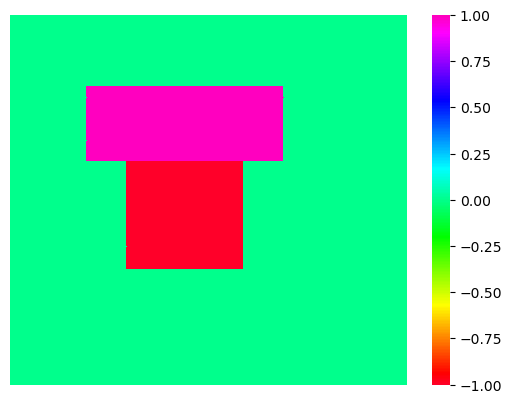

In [82]:
q = q_gen(128,'T')
sns.heatmap(q,**heatmap_params)

<AxesSubplot:>

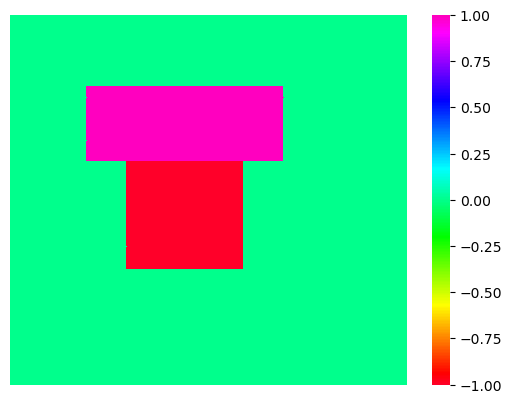

In [95]:
q1 = gaussian_filter(q, 0)
sns.heatmap(q1,**heatmap_params)

In [103]:
def q_circle(N, center_x = 0.5, center_y = 0.5, radius = 0.3):
    q = np.zeros((N+1, N+1))
    x, y = np.meshgrid(np.linspace(0, 1, N+1), np.linspace(0, 1, N+1))
    dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    q[dist <= radius] = 1
    return q

In [90]:
    x, y = np.meshgrid(np.linspace(0, 1, 65), np.linspace(0, 1, 65))

    # 计算圆心坐标和半径
    center_x, center_y = 0.5, 0.5
    radius = 0.3

    # 使用圆的方程将圆上的点设为1
    dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)

In [97]:
dist.dtype

dtype('float64')

<AxesSubplot:>

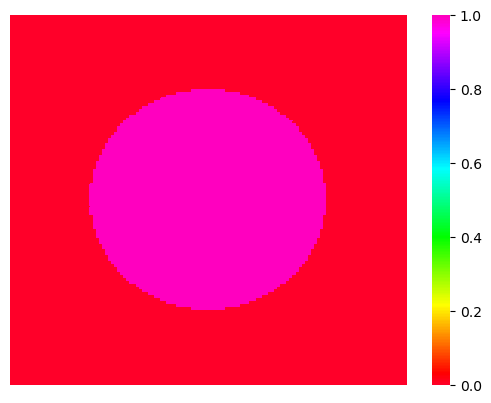

In [104]:
sns.heatmap(q_circle(128), **heatmap_params)

In [32]:
N = 64
m = 16
maxq = 0.1
k = [80]
noise_level = 0.0
q = q_gen(N, 'G', maxq)
Q = q.reshape(-1, )
matrix_A = gen_A(N)
N_in = 2 * N
q_in = q_gen(N_in, 'G', maxq)
Q_in = q_in.reshape(-1,)

In [33]:
f1,pd1 = data_gen(N, N, m, Q, k, matrix_A, noise_level)

In [34]:
f2,pd2 = data_gen(N_in, N, m, Q_in, k, matrix_A, noise_level)

In [35]:
np.linalg.norm(pd1-pd2)/np.linalg.norm(pd2)

1.549388198221582

<AxesSubplot:>

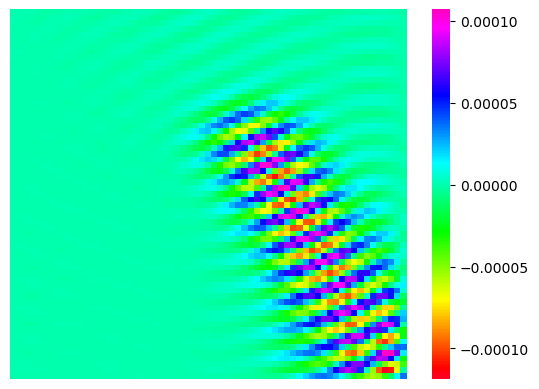

In [36]:
Matrix_analysis(N)
Matrix_factorize(N, k[0], Q)
tmp = Matrix_solve(Q * f1[0,1]).reshape((N+1,N+1))
sns.heatmap(tmp.real,**heatmap_params)

<AxesSubplot:>

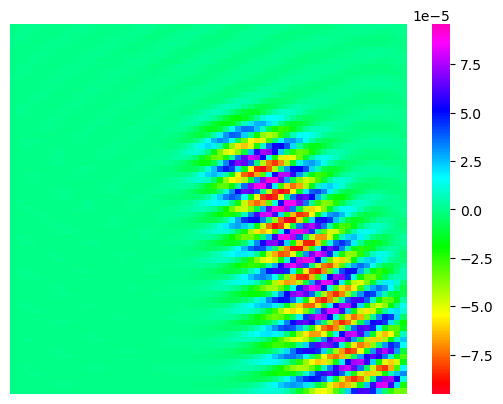

In [37]:
times = N_in // N
k_len = len(k)
f_data = np.zeros((k_len, m, (N_in+1)**2),dtype = np.complex128)
for j in range(k_len):
    f_data[j] = f_gen(N_in, k[0], m)
Matrix_analysis(N_in)
Matrix_factorize(N_in, k[0], Q_in)
tmp_u = Matrix_solve(Q_in * f_data[0,1]).reshape((N_in+1,N_in+1))[::times,::times]
sns.heatmap(tmp_u.real,**heatmap_params)

1.4921611959284697


<AxesSubplot:>

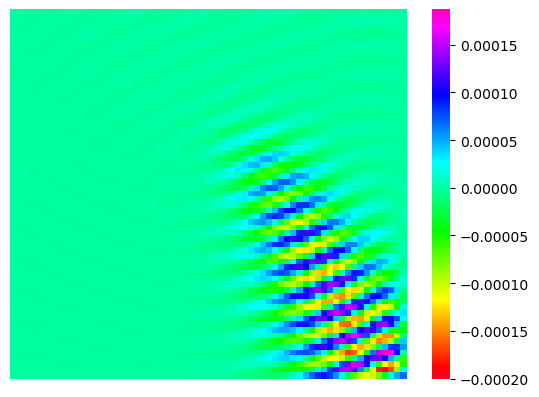

In [38]:
print(Error(tmp,tmp_u))
sns.heatmap(tmp.real-tmp_u.real,**heatmap_params)

In [39]:
def data_gen(N_in, N, m, Q_in, k, matrix_A, noise_level):
    times = N_in // N
    k_len = len(k)
    f_data = np.zeros((k_len, m, (N_in+1)**2),dtype = np.complex128)
    for j in range(k_len):
        f_data[j] = f_gen(N_in, k[j], m)
    f_data_output = f_data.reshape(k_len,m,N_in+1,N_in+1)[...,
                                ::times,::times].reshape((k_len,m,(N+1)**2))
    partial_data = np.zeros((k_len,m,4*N-4),dtype = np.complex128)
    Matrix_analysis(N_in)
    for j in range(k_len):
        Matrix_factorize(N_in, k[j], Q_in)
        for i in range(m):
            tmp_u = Matrix_solve(Q_in * f_data[j,i]).reshape((N_in+1,
                                N_in+1))[::times,::times].reshape(-1,)
            partial_data[j,i] = Round(matrix_A @ tmp_u, noise_level)
    return f_data_output, partial_data